### Tokenize
Trying different tokenize methods


In [1]:
import os
from pathlib import Path
import pandas as pd
from transformers import GPT2Tokenizer

import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
data_path = Path(os.getcwd()).parent / 'data'
df = pd.read_csv(f'{data_path}/genre_lyric-data.csv')

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [4]:
from tqdm import tqdm
tqdm.pandas()
df['token_count'] = df['lyrics'].progress_apply(lambda x: len(tokenizer.encode(x)))


100%|██████████| 40253/40253 [01:08<00:00, 589.59it/s] 


In [5]:
display(df['token_count'].describe())
print(f"\n90th percentile: {df['token_count'].quantile(0.90):.0f} tokens")
print(f"95th percentile: {df['token_count'].quantile(0.95):.0f} tokens")
print(f"99th percentile: {df['token_count'].quantile(0.99):.0f} tokens")

for max_len in [256, 512, 768, 1024]:
    kept = (df['token_count'] <= max_len).sum()
    lost = (df['token_count'] > max_len).sum()
    kept_pct = kept / len(df) * 100
    lost_pct = lost / len(df) * 100
    
    print(f"Max length {max_len} tokens:")
    print(f" Keep: {kept:,} songs ({kept_pct:.1f}%)")
    print(f" Lose: {lost:,} songs ({lost_pct:.1f}%)")

count    40253.000000
mean       319.875810
std        221.496667
min          2.000000
25%        199.000000
50%        285.000000
75%        399.000000
max      14785.000000
Name: token_count, dtype: float64


90th percentile: 535 tokens
95th percentile: 636 tokens
99th percentile: 883 tokens
Max length 256 tokens:
 Keep: 16,823 songs (41.8%)
 Lose: 23,430 songs (58.2%)
Max length 512 tokens:
 Keep: 35,478 songs (88.1%)
 Lose: 4,775 songs (11.9%)
Max length 768 tokens:
 Keep: 39,415 songs (97.9%)
 Lose: 838 songs (2.1%)
Max length 1024 tokens:
 Keep: 40,063 songs (99.5%)
 Lose: 190 songs (0.5%)


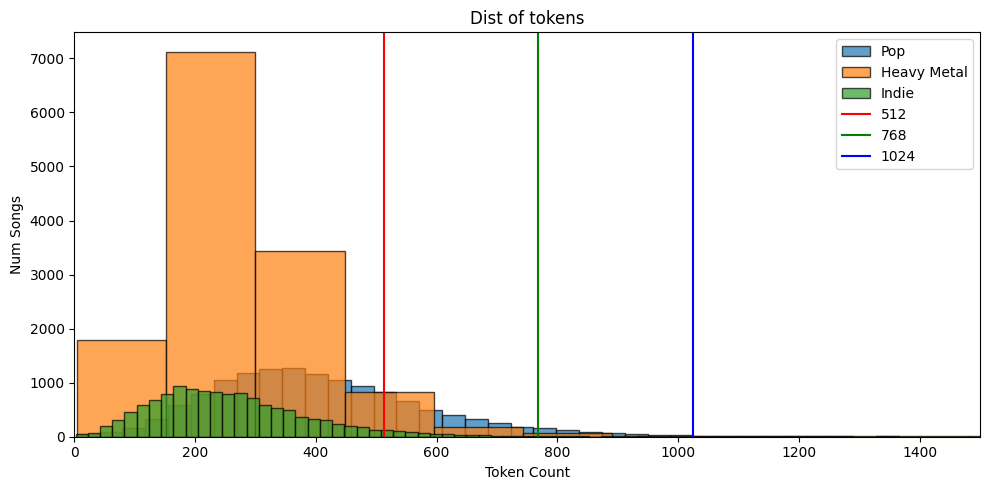

In [6]:
genres = df['genre'].value_counts().index[:3]
plt.figure(figsize=(10, 5))
for genre in genres:
    subset = df[df['genre'] == genre]
    plt.subplot()
    plt.hist(
        subset['token_count'],
        bins=100,  
        edgecolor='black',
        alpha=0.7,
        label=genre
    )

for x, color, label in zip([512, 768, 1024], ['red', 'green', 'blue'], ['512', '768', '1024']):
    plt.axvline(x, color=color, label=label)   
plt.xlim(0, 1500) 

plt.xlabel('Token Count')
plt.ylabel('Num Songs')
plt.title(f'Dist of tokens')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
MAX_LENGTH = 768

df_filtered = df[df['token_count'] <= MAX_LENGTH].copy()
df_filtered = df_filtered.drop(columns=['song_name'])
df_filtered['formatted_text'] = df_filtered.apply(
    lambda row: f"Genre: {row['genre']}\n\n{row['lyrics']}<|endoftext|>", 
    axis=1
)
df_filtered.to_csv(f'{data_path}/lyrics_filtered_768tokens.csv', index=False)